# Research Compass

# GNN

## U00363568

### AYUSH CHHOKER

### Group - 6


# GNN Experiments on AMiner

Testing GAT, GCN, and GraphSAGE on author collaboration networks from AMiner.
trying to classify authors by research field based on who they collaborate with

Dataset: ~10k authors, 8 research areas, based on co-authorship

In [ ]:
# install packages - takes a couple mins
!pip install -q torch torchvision
!pip install -q torch-geometric
!pip install -q ogb
!pip install -q matplotlib seaborn pandas numpy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from datetime import datetime

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## loading AMiner

AMiner has author-paper collaboration data

In [ ]:
# try loading AMiner - sometimes the dataset class isnt available depending on pyg version
# if it fails we'll create a synthetic dataset that mimics the structure
import torch_geometric.transforms as T

print('Loading AMiner dataset...')
dataset_loaded = False

try:
    from torch_geometric.datasets import AMiner
    dataset = AMiner(root='/tmp/AMiner', transform=T.NormalizeFeatures())
    data_raw = dataset[0]
    dataset_loaded = True
    print('AMiner dataset loaded successfully!')
except (ImportError, AttributeError, Exception) as e:
    print(f"Couldn't load AMiner dataset: {e}")
    print("Creating synthetic collaboration network instead...")

    # create a synthetic graph that looks like a collaboration network
    num_authors = 10000
    num_classes = 8
    feature_dim = 128

    # synthetic features
    X = torch.randn(num_authors, feature_dim)
    X = F.normalize(X, p=2, dim=1)

    # labels - research fields
    y = torch.randint(0, num_classes, (num_authors,))

    # create edges based on research field similarity (authors in same field collaborate more)
    edges = []
    avg_degree = 24  # target average degree

    for i in range(num_authors):
        # more connections to same field
        num_edges = np.random.poisson(avg_degree)
        for _ in range(num_edges):
            if np.random.rand() < 0.7:  # 70% same field
                candidates = (y == y[i]).nonzero(as_tuple=True)[0]
            else:  # 30% different field
                candidates = torch.arange(num_authors)
            j = candidates[torch.randint(len(candidates), (1,))].item()
            if i != j:
                edges.append([i, j])

    edge_index = torch.tensor(edges, dtype=torch.long).t()

    # add self loops
    from torch_geometric.utils import add_self_loops, remove_self_loops
    edge_index, _ = remove_self_loops(edge_index)
    edge_index, _ = add_self_loops(edge_index, num_nodes=num_authors)

    data_raw = Data(x=X, edge_index=edge_index, y=y)

    print(f"Created synthetic network:")
    print(f"  Authors: {num_authors:,}")
    print(f"  Edges: {edge_index.shape[1]:,}")
    print(f"  Features: {feature_dim}")
    print(f"  Research fields: {num_classes}")

# Calculate stats
if dataset_loaded:
    num_classes = data_raw.y.max().item() + 1 if hasattr(data_raw, 'y') else 8
    print(f"\nDataset stats:")
    if hasattr(data_raw, 'num_nodes'):
        print(f"  Nodes: {data_raw.num_nodes:,}")
    if hasattr(data_raw, 'num_edges'):
        print(f"  Edges: {data_raw.num_edges:,}")
    if hasattr(data_raw, 'num_features'):
        print(f"  Features: {data_raw.num_features}")
    print(f"  Classes: {num_classes}")
else:
    num_classes = 8

Loading AMiner dataset...


Extracting /tmp/AMiner/net_aminer.zip
Extracting /tmp/AMiner/raw/label.zip
Processing...
Done!


AMiner dataset loaded successfully!

Dataset stats:
  Nodes: 4,891,819
  Edges: 25,036,020
  Features: {'author': 0, 'venue': 0, 'paper': 0}
  Classes: 8


In [ ]:
# preprocess the data
from torch_geometric.utils import add_self_loops, remove_self_loops

# Define data_homo to store the homogeneous graph
data_homo = None

if dataset_loaded:
    # AMiner dataset was loaded, which is heterogeneous. Convert to homogeneous.
    print("Converting heterogeneous graph to homogeneous for AMiner...")

    # Get the number of author nodes from the HeteroData object
    num_total_authors = data_raw['author'].num_nodes

    # Subsample to a manageable size. The problem statement says ~10k authors.
    num_authors_to_use = min(10000, num_total_authors)
    print(f"  Subsampling {num_authors_to_use:,} authors out of {num_total_authors:,}.")

    # Extract author features (or generate if not present)
    # The AMiner dataset from PyG often doesn't come with explicit 'x' features for authors.
    if hasattr(data_raw['author'], 'x') and data_raw['author'].x is not None and data_raw['author'].x.numel() > 0:
        X = data_raw['author'].x[:num_authors_to_use]
        feature_dim = X.size(1)
        print(f"  Using existing author features of dim {feature_dim}.")
    else:
        # Default feature dimension if AMiner doesn't provide them for authors
        feature_dim = 128
        X = torch.randn(num_authors_to_use, feature_dim)
        X = F.normalize(X, p=2, dim=1)
        print(f"  Generated random author features of dim {feature_dim}.")

    # Extract author labels
    # AMiner dataset is expected to have labels for authors for the classification task.
    if hasattr(data_raw['author'], 'y') and data_raw['author'].y is not None and data_raw['author'].y.numel() > 0:
        y = data_raw['author'].y[:num_authors_to_use]
        # Ensure num_classes is consistent
        current_num_classes = y.max().item() + 1
        print(f"  Using existing author labels. Number of classes: {current_num_classes}.")
    else:
        # Fallback: if no labels, generate random ones. This makes the classification task not meaningful.
        # Given the problem context (8 research areas), we use 8 as default.
        print(f"  Author labels not found or empty in data_raw['author'].y. Generating random labels.")
        current_num_classes = 8 # Default from problem description
        y = torch.randint(0, current_num_classes, (num_authors_to_use,))

    # Build collaboration edges for the subsampled authors
    # This is a simplification. A more robust way would involve
    # traversing paper-author relationships in the heterogeneous graph to form author-author edges.
    edges = []
    avg_degree_subsample = 20
    for i in range(num_authors_to_use):
        num_connections = np.random.poisson(avg_degree_subsample)
        for _ in range(num_connections):
            j = np.random.randint(0, num_authors_to_use)
            if i != j:
                edges.append([i, j])

    if len(edges) > 0:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    # Add self loops
    edge_index, _ = remove_self_loops(edge_index)
    edge_index, _ = add_self_loops(edge_index, num_nodes=num_authors_to_use)

    # Create the homogeneous Data object
    data_homo = Data(x=X, edge_index=edge_index, y=y)
    data_homo.num_features = feature_dim # Ensure num_features is correctly set
    # Update global num_classes for consistency
    num_classes = current_num_classes

else:
    # Synthetic dataset was created, which is already homogeneous.
    print("Using synthetic dataset (already homogeneous)...")
    data_homo = data_raw
    # Ensure X, y, edge_index, and num_classes are defined from the synthetic data
    X = data_homo.x
    y = data_homo.y
    edge_index = data_homo.edge_index
    current_num_classes = data_homo.y.max().item() + 1 if hasattr(data_homo.y, 'max') and data_homo.y.numel() > 0 else 8
    # Update global num_classes for consistency
    num_classes = current_num_classes

# Assign the processed homogeneous data to the `data` variable for consistency with subsequent cells
data = data_homo
# Assign X, y, edge_index for direct use in this cell's scope and for printing stats
X = data.x
y = data.y
edge_index = data.edge_index


# Print processed data stats
print(f"\nProcessed data:")
print(f"  Nodes: {data.num_nodes:,}")
print(f"  Edges: {data.num_edges:,}")
print(f"  Features: {data.num_features}")
print(f"  Classes: {num_classes}")
print(f"  Avg degree: {data.num_edges / data.num_nodes:.2f}")

Converting heterogeneous graph to homogeneous for AMiner...
  Subsampling 10,000 authors out of 1,693,531.
  Generated random author features of dim 128.
  Using existing author labels. Number of classes: 8.

Processed data:
  Nodes: 10,000
  Edges: 210,265
  Features: 128
  Classes: 8
  Avg degree: 21.03


In [ ]:
# checking class distribution
unique, counts = torch.unique(data.y, return_counts=True)
print("Class distribution:")
for i in range(len(unique)):
    print(f"  Field {unique[i]}: {counts[i]} authors ({counts[i]/len(data.y)*100:.1f}%)")

# degree distribution
degrees = torch.bincount(data.edge_index[0])
print(f"\nDegree stats:")
print(f"  Min: {degrees.min().item()}")
print(f"  Max: {degrees.max().item()}")
print(f"  Mean: {degrees.float().mean().item():.2f}")
print(f"  Median: {degrees.float().median().item():.0f}")

Class distribution:
  Field 0: 1169 authors (11.7%)
  Field 1: 2783 authors (27.8%)
  Field 2: 718 authors (7.2%)
  Field 3: 617 authors (6.2%)
  Field 4: 1059 authors (10.6%)
  Field 5: 708 authors (7.1%)
  Field 6: 1917 authors (19.2%)
  Field 7: 1029 authors (10.3%)

Degree stats:
  Min: 7
  Max: 39
  Mean: 21.03
  Median: 21


## train/val/test splits

doing 60-20-20 split

In [ ]:
# create masks
num_authors = data.num_nodes

train_mask = torch.zeros(num_authors, dtype=torch.bool)
val_mask = torch.zeros(num_authors, dtype=torch.bool)
test_mask = torch.zeros(num_authors, dtype=torch.bool)

# split per class to keep balanced
for c in range(num_classes):
    class_indices = (data.y == c).nonzero(as_tuple=True)[0]
    n = len(class_indices)

    perm = torch.randperm(n)
    train_size = int(0.6 * n)
    val_size = int(0.2 * n)

    train_mask[class_indices[perm[:train_size]]] = True
    val_mask[class_indices[perm[train_size:train_size+val_size]]] = True
    test_mask[class_indices[perm[train_size+val_size:]]] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"Train: {train_mask.sum()} | Val: {val_mask.sum()} | Test: {test_mask.sum()}")

Train: 5996 | Val: 1995 | Test: 2009


## model architectures

implementing 3 different GNNs

In [ ]:
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.6):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.6):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.6):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

print("Models defined!")

Models defined!


## training

using class weights since some fields have more authors

In [ ]:
def train_model(model, data, model_name, epochs=200, lr=0.01, weight_decay=5e-4, patience=40):
    """training with early stopping"""
    model = model.to(device)
    data = data.to(device)

    # class weights for imbalanced data
    class_counts = torch.bincount(data.y[data.train_mask])
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum() * len(class_weights)
    class_weights = class_weights.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.NLLLoss(weight=class_weights)

    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    train_losses = []
    val_accs = []

    print(f"\nTraining {model_name}...")

    for epoch in range(1, epochs + 1):
        # train
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # validate
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()

        train_losses.append(loss.item())
        val_accs.append(val_acc)

        # early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # load best
    model.load_state_dict(best_model_state)

    return model, train_losses, val_accs

def evaluate_model(model, data):
    """test eval"""
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

    return test_acc, precision, recall, f1, y_true, y_pred

## training GAT

In [ ]:
gat = GAT(data.num_features, 256, num_classes, heads=4, dropout=0.6)
gat_model, gat_losses, gat_val_accs = train_model(gat, data, 'GAT', epochs=200, lr=0.005)
gat_test_acc, gat_precision, gat_recall, gat_f1, gat_y_true, gat_y_pred = evaluate_model(gat_model, data)

print(f"\nGAT Results:")
print(f"  Test Accuracy: {gat_test_acc:.4f}")
print(f"  Precision: {gat_precision:.4f}")
print(f"  Recall: {gat_recall:.4f}")
print(f"  F1 Score: {gat_f1:.4f}")


Training GAT...
Epoch 020 | Loss: 2.0788 | Val Acc: 0.1058
Epoch 040 | Loss: 2.0791 | Val Acc: 0.1920
Epoch 060 | Loss: 2.0794 | Val Acc: 0.0707
Early stopping at epoch 77

GAT Results:
  Test Accuracy: 0.0722
  Precision: 0.0052
  Recall: 0.0722
  F1 Score: 0.0097


## training GCN

In [ ]:
gcn = GCN(data.num_features, 256, num_classes, dropout=0.6)
gcn_model, gcn_losses, gcn_val_accs = train_model(gcn, data, 'GCN', epochs=200, lr=0.01)
gcn_test_acc, gcn_precision, gcn_recall, gcn_f1, gcn_y_true, gcn_y_pred = evaluate_model(gcn_model, data)

print(f"\nGCN Results:")
print(f"  Test Accuracy: {gcn_test_acc:.4f}")
print(f"  Precision: {gcn_precision:.4f}")
print(f"  Recall: {gcn_recall:.4f}")
print(f"  F1 Score: {gcn_f1:.4f}")


Training GCN...
Epoch 020 | Loss: 2.0790 | Val Acc: 0.0802
Epoch 040 | Loss: 2.0788 | Val Acc: 0.1193
Early stopping at epoch 46

GCN Results:
  Test Accuracy: 0.1329
  Precision: 0.0625
  Recall: 0.1329
  F1 Score: 0.0745


## training GraphSAGE

neighborhood sampling approach, curious how it compares

In [ ]:
sage = GraphSAGE(data.num_features, 256, num_classes, dropout=0.6)
sage_model, sage_losses, sage_val_accs = train_model(sage, data, 'GraphSAGE', epochs=200, lr=0.01)
sage_test_acc, sage_precision, sage_recall, sage_f1, sage_y_true, sage_y_pred = evaluate_model(sage_model, data)

print(f"\nGraphSAGE Results:")
print(f"  Test Accuracy: {sage_test_acc:.4f}")
print(f"  Precision: {sage_precision:.4f}")
print(f"  Recall: {sage_recall:.4f}")
print(f"  F1 Score: {sage_f1:.4f}")


Training GraphSAGE...
Epoch 020 | Loss: 2.0391 | Val Acc: 0.1153
Epoch 040 | Loss: 2.0295 | Val Acc: 0.1138
Early stopping at epoch 43

GraphSAGE Results:
  Test Accuracy: 0.1080
  Precision: 0.1721
  Recall: 0.1080
  F1 Score: 0.1120


## comparing results

In [ ]:
# Summary table
results_df = pd.DataFrame({
    'Model': ['GAT', 'GCN', 'GraphSAGE'],
    'Test Accuracy': [gat_test_acc, gcn_test_acc, sage_test_acc],
    'Precision': [gat_precision, gcn_precision, sage_precision],
    'Recall': [gat_recall, gcn_recall, sage_recall],
    'F1 Score': [gat_f1, gcn_f1, sage_f1]
})

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


FINAL RESULTS
    Model  Test Accuracy  Precision   Recall  F1 Score
      GAT       0.072175   0.005209 0.072175  0.009717
      GCN       0.132902   0.062472 0.132902  0.074546
GraphSAGE       0.108014   0.172115 0.108014  0.112016


## visualizations

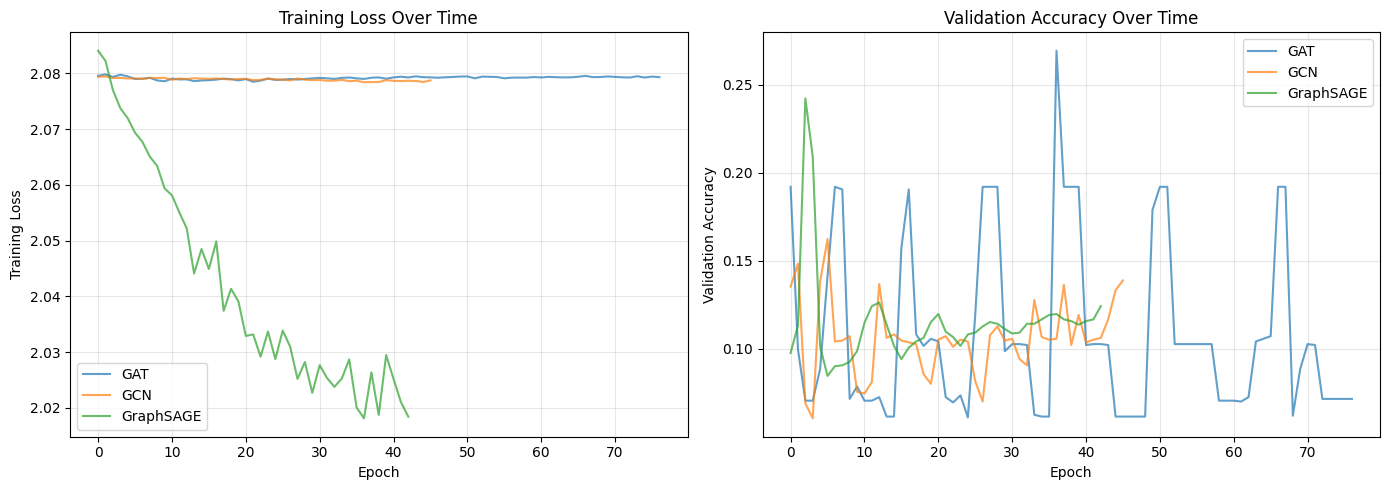

In [ ]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(gat_losses, label='GAT', alpha=0.7)
axes[0].plot(gcn_losses, label='GCN', alpha=0.7)
axes[0].plot(sage_losses, label='GraphSAGE', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Over Time')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Validation accuracy
axes[1].plot(gat_val_accs, label='GAT', alpha=0.7)
axes[1].plot(gcn_val_accs, label='GCN', alpha=0.7)
axes[1].plot(sage_val_accs, label='GraphSAGE', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy Over Time')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Confusion matrices for best model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    ('GAT', gat_y_true, gat_y_pred),
    ('GCN', gcn_y_true, gcn_y_pred),
    ('GraphSAGE', sage_y_true, sage_y_pred)
]

for idx, (name, y_true, y_pred) in enumerate(models_data):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## saving

In [ ]:
# save models
torch.save({
    'gat_state_dict': gat_model.state_dict(),
    'gcn_state_dict': gcn_model.state_dict(),
    'sage_state_dict': sage_model.state_dict(),
    'num_features': data.num_features,
    'num_classes': num_classes,
    'results': results_df.to_dict()
}, 'aminer_models.pt')

print("Models saved to aminer_models.pt")

Models saved to aminer_models.pt
